7.2.2021

### Image Processing in Physics

#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

# Exercise 1: Noisy Tomography

This exercise will be about tomographic reconstruction of noisy data using 
different filters with filtered backprojection.


The exercise consists of two  parts:

* First, you need to create both filters, a Ramlak and a Hamming filter.
The Hamming filter has a reduced high-frequency response. This assumes that the 
very high frequencies mostly contain noise. The Hamming filter is defined as : $H(u) = 0.54 + 0.46 \cos(2 \pi u)$ with $u$ being 
the frequencies in Fourier space. It has to be multiplied on top of the usual ramp filter.
(The original Hamming function has a minus in it (not a plus), but we have to
keep the low frequencies. Therefore, we changed the sign, corresponding to a
wrapping.)
* Second, you will reconstruct the given noisy sinogram with both reconstruction
filter. Compare the reconstructions and their noise standard deviation in 
corresponding regions.

You need to replace the `???` in the code with the required commands.

In [1]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

%matplotlib notebook
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

Define a function for performing the backprojection.

In [29]:
def backproject(sinogram, angles):
    """
    Backproject a given sinogram.
    Hints
    -----
    Perform the backprojection inversely to the way we did the
    forwardprojection, by smearing each projection in the sinogram back along
    the axis that you summed before in forwardproject(),
    then rotating the resulting backprojection
    to get the right backprojection angle.
    Use scipy.ndimage.rotate(..., ..., reshape=False)
    """
    # calculate number of projections, and pixels
    nproj, npix = sinogram.shape
    
    # define empty container for reconstruction of sample
    reconstruction = np.zeros([npix, npix], dtype=sinogram.dtype)

    # loop over all projections
    for i, ang in enumerate(angles):
        print("Reconstructing: %03i / %i" % (i + 1, nproj), end="\r", flush=True)

        backprojection = np.tile(sinogram[i], (npix, 1))
        backprojection /= nproj  # Just normalization

        rotated_backprojection = nd.rotate(backprojection, -ang, reshape=False, order=1)

        # Add the rotated backprojection
        reconstruction += rotated_backprojection

    return reconstruction

First, we read a noisy sinogram:

In [10]:
sinogram = np.load('noisy_sino.npy')

# Get the number of angles an the length of the detector from the sinogram.
nproj, npix = sinogram.shape

# Define the vector containing the projection angles. They were sampled 
# equidistantly over a 360° rotation.
angles = np.linspace(0, 360., nproj, False)

<IPython.core.display.Javascript object>


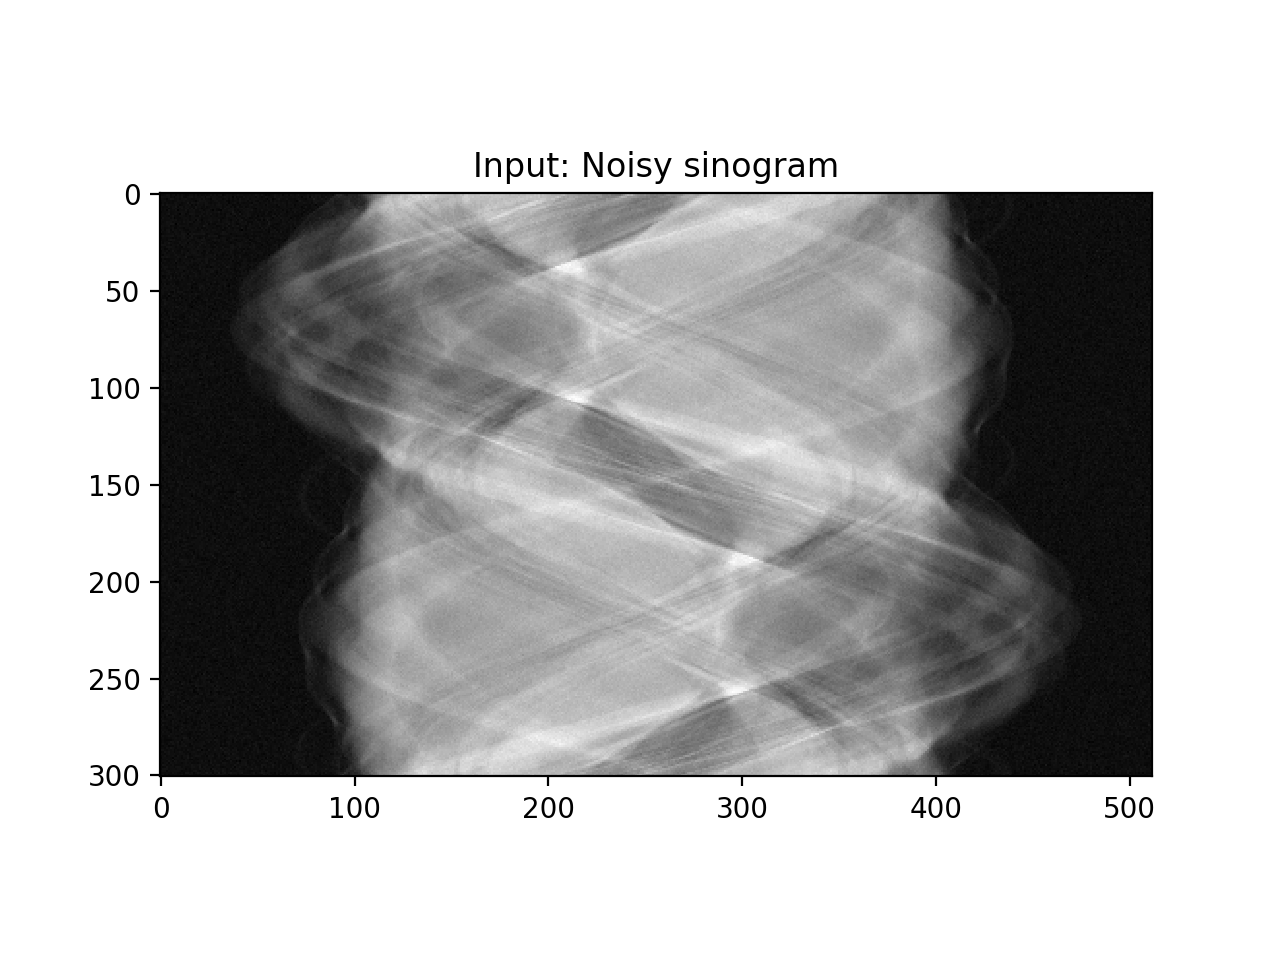

Text(0.5, 1.0, 'Input: Noisy sinogram')

In [11]:
plt.figure()
plt.imshow(sinogram)
plt.title("Input: Noisy sinogram")

Next, we define the Ramlak and Hamming filters. Remember that Hamming is a product of Ramlak and the formula in the beginning.

In [20]:
# Generate the basic ramp filter (hint: np.fft.fftfreq)
freq = np.fft.fftfreq(npix)
ramlak_filter = np.pi * np.abs(freq)

# Generate the Hamming filter from adapting the ramp filter.
hamming_filter = ramlak_filter*(0.54+0.46*np.cos(2*np.pi*freq))

Plot both filters in one graph to investigate their frequency response.

<IPython.core.display.Javascript object>


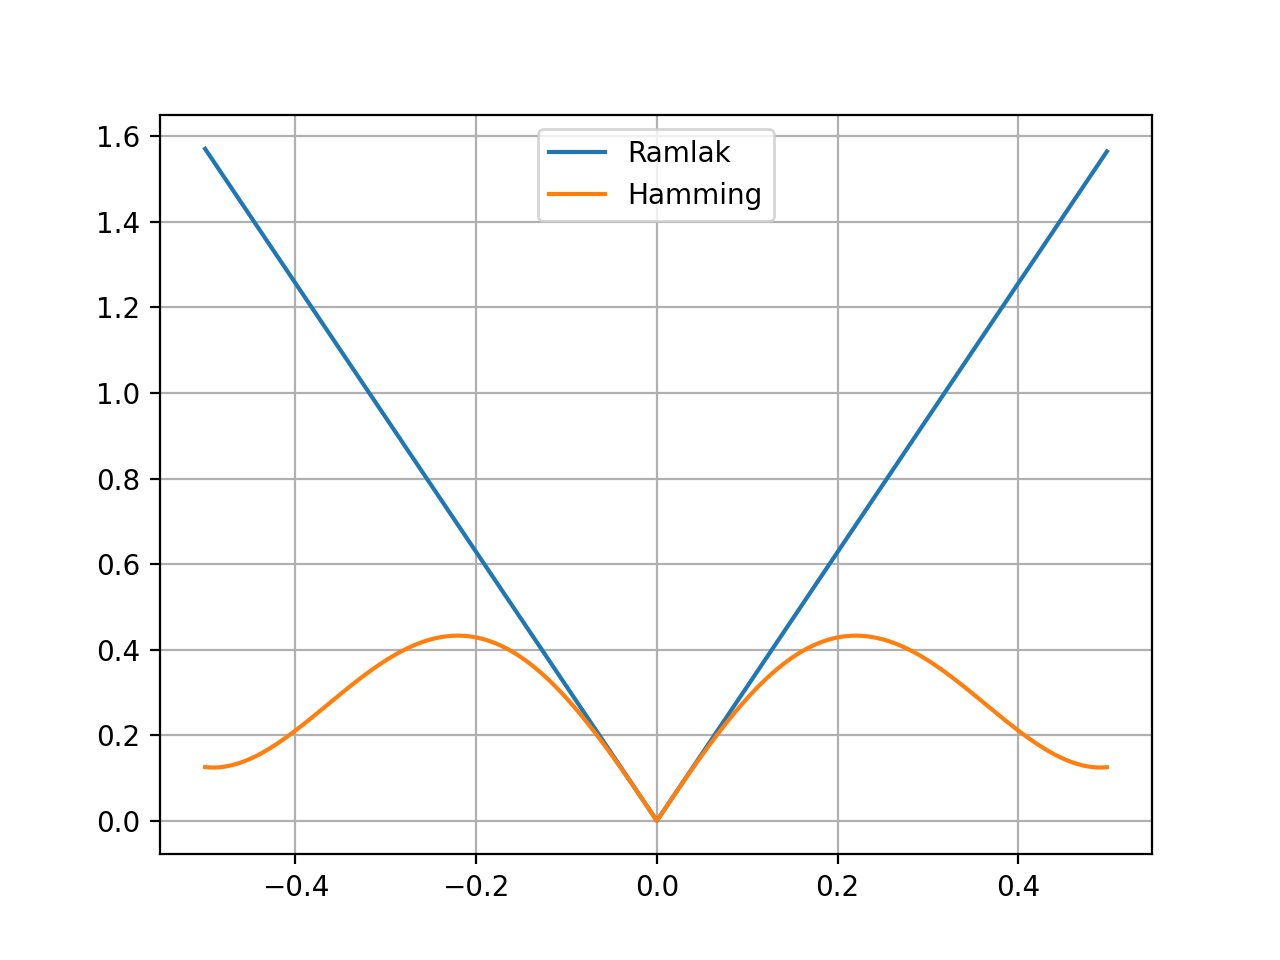

In [21]:
plt.figure()
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(ramlak_filter), label='Ramlak')
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(hamming_filter), label='Hamming')
plt.grid(True)
plt.legend()

Perform the reconstructions for both filters by applying them to the projections and performing the backprojection.

In [22]:
# Transfer the sinogram to Fourier space in detector pixel direction.
# Use the np.fft.fft along the axis=1
sino_ft = np.fft.fft(sinogram, axis=1)

# Multiply the ramp filter onto the 1D-FT of the sinogram and transform it
# back into spatial domain. Also use the Hamming filter.
sino_ramlak = np.real(np.fft.ifft(ramlak_filter*sino_ft, axis=1))
sino_hamming = np.real(np.fft.ifft(hamming_filter * sino_ft, axis=1))

# reconstruct the image from its filtered sinogram
reco_ramlak = backproject(sino_ramlak, angles)
reco_hamming = backproject(sino_hamming, angles)

Visualize the filtered sinograms and reconstructions of both filters. The visual noise level is very high for the Ramlak filter while the hamming sinogram and reconstruction look smooth. Hamming filter smoothes high frequencies, which corresponde to noise

But lower noise level leads to a decreased spatial resolution. In the end, what filter to use depends on the application and most importantly on the person looking at the data -- for this image it would be a radiologist.

<IPython.core.display.Javascript object>


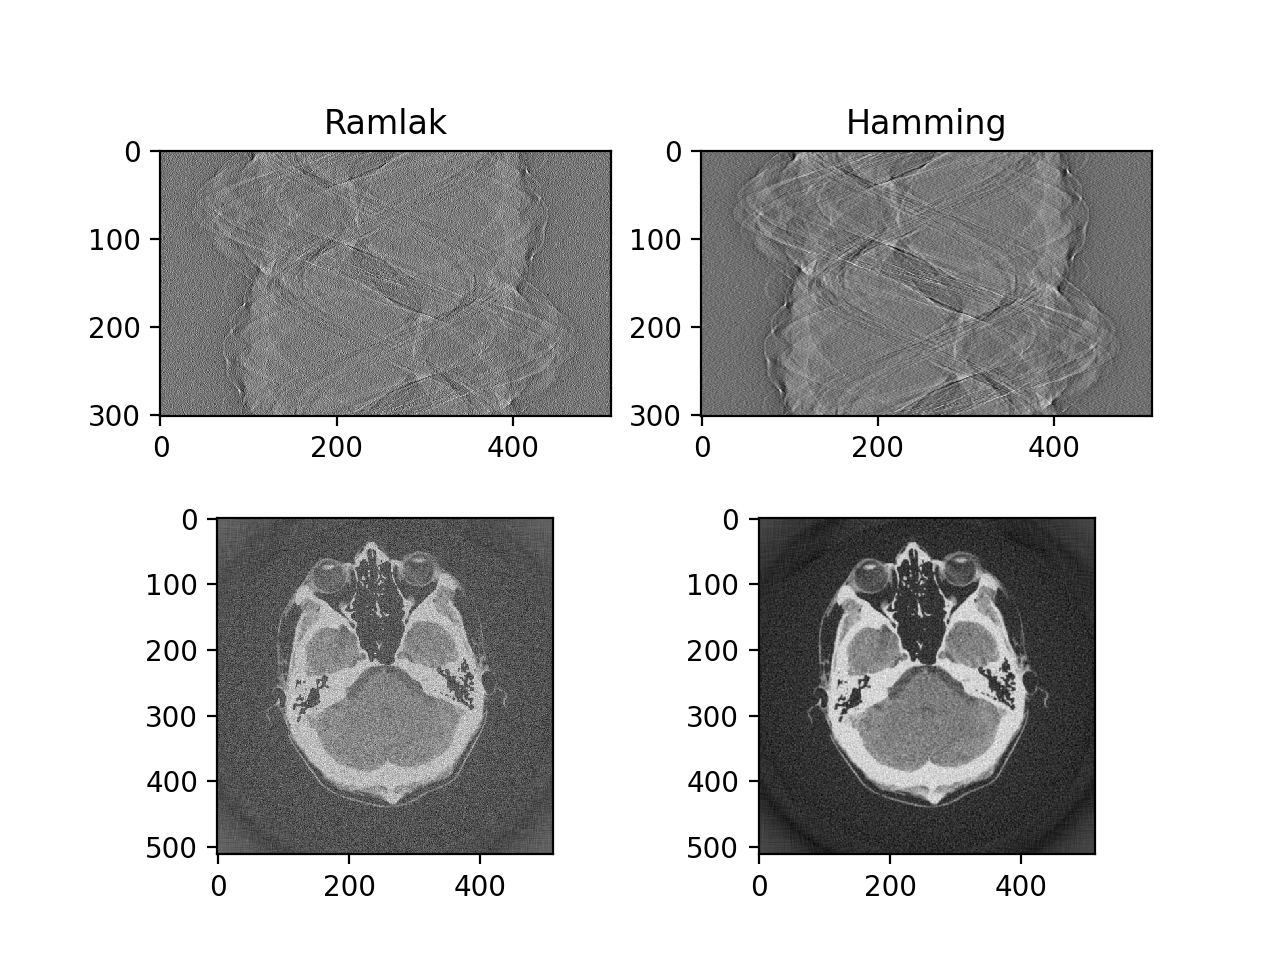

In [23]:
plt.figure()
plt.subplot(221)
plt.imshow(sino_ramlak)
plt.title("Ramlak")
plt.subplot(222)
plt.imshow(sino_hamming)
plt.title("Hamming")
plt.subplot(223)
plt.imshow(reco_ramlak)
plt.subplot(224)
plt.imshow(reco_hamming)

A somewhat quantitative measure of image quality is the Signal-to-Noise ratio (SNR). We define it as 

$$
\mathrm{SNR} = \frac{\mu}{\sigma} \,,
$$

so the mean over the standard deviation of the signal. To compare two images, we choose the same region in both images with approximately constant signal and compute the respective SNRs. Technically the SNR will be different for different regions (e.g. brain matter or bone), but here we choose a single region.

Choose a homogeneous region in e.g. the bone of the skull and perform a signal to noise analysis by comparing SNRs. Which filter performs better?

In [28]:
region = np.s_[270:350, 200:300]
region_ramlak = reco_ramlak[region]
region_hamming = reco_hamming[region]

snr_ramlak = np.mean(region_ramlak)/np.std(region_ramlak)
snr_hamming = np.mean(region_hamming)/np.std(region_hamming)

print("SNR")
print("Ramlak:  %05.2f" % snr_ramlak)
print("Hamming: %05.2f" % snr_hamming)

SNR
Ramlak:  01.74
Hamming: 03.86


In [27]:
np.s_?